In [ ]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))
import cv2
import imghdr
data_dir = 'signatures' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
data = tf.keras.utils.image_dataset_from_directory('signatures')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

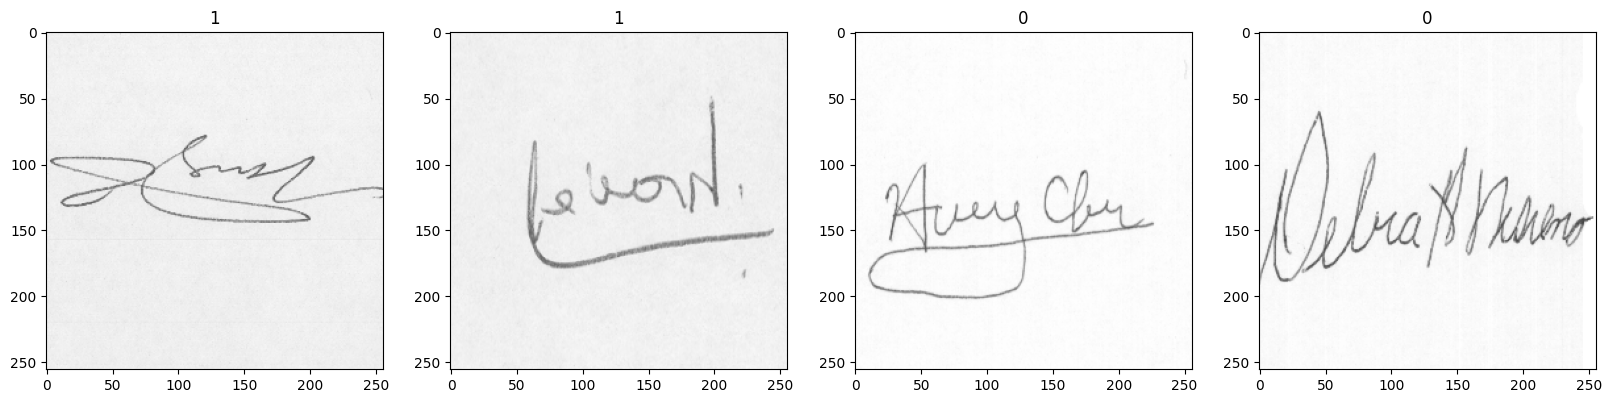

In [3]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [4]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [5]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
import pandas as pd
dict={"name":['Adadelta','Adagrad','Adam','Adamax','Ftrl','Nadam','SGD','RMSprop']}

In [7]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('Adamax', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [8]:
logdir='adamax'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [10]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
58/58 [==============================] - 5s 78ms/step - loss: 0.3477 - accuracy: 0.8561 - val_loss: 0.2686 - val_accuracy: 0.9336
Epoch 2/25
58/58 [==============================] - 5s 78ms/step - loss: 0.3291 - accuracy: 0.8605 - val_loss: 0.2507 - val_accuracy: 0.9277
Epoch 3/25
58/58 [==============================] - 5s 77ms/step - loss: 0.1891 - accuracy: 0.9429 - val_loss: 0.1757 - val_accuracy: 0.9453
Epoch 4/25
58/58 [==============================] - 5s 76ms/step - loss: 0.1998 - accuracy: 0.9240 - val_loss: 0.1303 - val_accuracy: 0.9688
Epoch 5/25
58/58 [==============================] - 5s 77ms/step - loss: 0.1114 - accuracy: 0.9747 - val_loss: 0.0952 - val_accuracy: 0.9805
Epoch 6/25
58/58 [==============================] - 5s 77ms/step - loss: 0.1016 - accuracy: 0.9677 - val_loss: 0.0720 - val_accuracy: 0.9844
Epoch 7/25
58/58 [==============================] - 5s 77ms/step - loss: 0.0824 - accuracy: 0.9752 - val_loss: 0.0730 - val_accuracy: 0.9863
Epoch 8/25
58

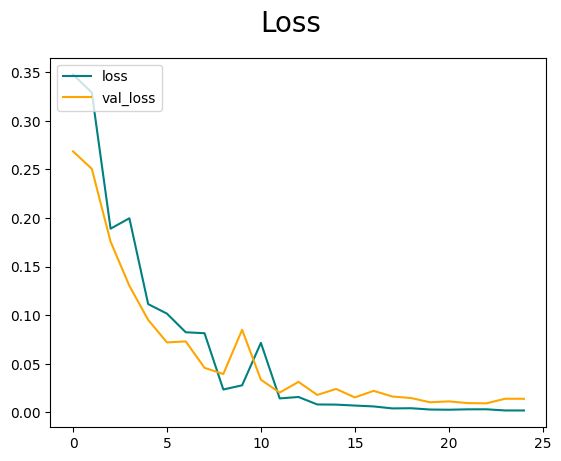

In [11]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

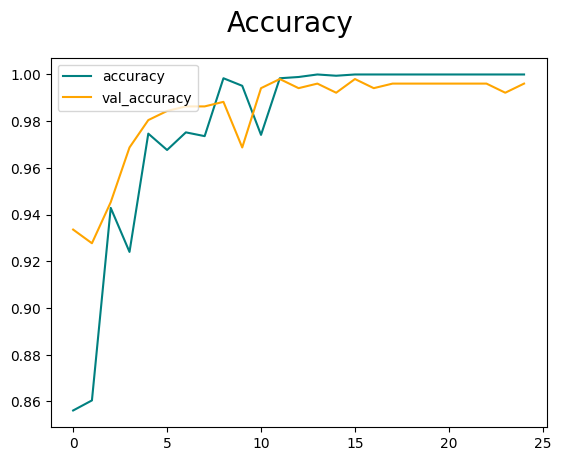

In [12]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [23]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 24ms/step


In [24]:
print(f'{pre.result()}, {re.result()}, {acc.result()}')

0.985401451587677, 1.0, 0.9921875


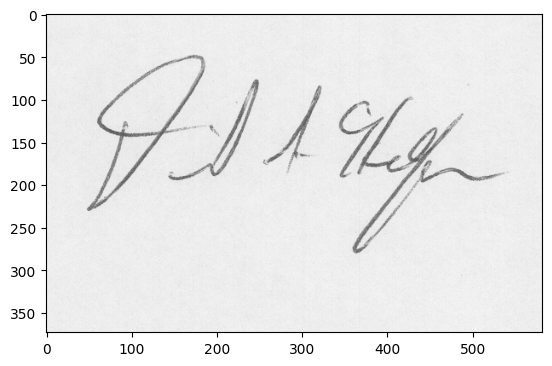

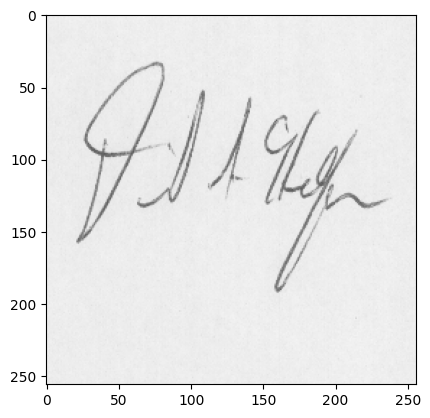

In [3]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('signatures/full_org/original_10_18.png')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [26]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 16ms/step


In [27]:
yhat

array([[0.999775]], dtype=float32)

In [28]:
if yhat > 0.5: 
    print(f'Predicted class is original')
else:
    print(f'Predicted class is forged')

Predicted class is original


In [4]:
from tensorflow.keras.models import load_model


In [ ]:
model.save(os.path.join('models','adamax.h5'))

In [5]:
new_model = load_model('models/imageclassifier.h5')

In [6]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 200ms/step


array([[0.45789158]], dtype=float32)

In [ ]:
for i in Var:
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(i, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
    model.summary()
    logdir=i
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])
    pre = Precision()
    re = Recall()
    acc = BinaryAccuracy()
    for batch in test.as_numpy_iterator(): 
        X, y = batch
        yhat = model.predict(X)
        pre.update_state(y, yhat)
        re.update_state(y, yhat)
        acc.update_state(y, yhat)
    dict={"names":i,"precision":pre.result(),"recall":re.result(),"accuracy":acc.result()}
    df1=pd.DataFrame.from_dict(dict)
    df2=df1.append(df1 ,ignore_index=True)
df2
